<a href="https://colab.research.google.com/github/milanzongor/ntut_dl_273045_project1/blob/master/ntut_deep_learning_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep learning project 1 - Denoising autoencoder




In [0]:
#imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten, Dropout
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


PATH = '/content/drive/My Drive/DEEP/DL1/'
EPOCHS = 30

Using TensorFlow backend.


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# Getting of the mnist

In [0]:
# Load mnist from data preparation notebook result

x_train_fc = np.load(PATH + "train_data.npz")['x_train_fc']
x_train_gauss = np.load(PATH + "train_data.npz")['x_train_gauss']
x_train_salt_pepper = np.load(PATH + "train_data.npz")['x_train_salt_pepper']
x_train_poisson = np.load(PATH + "train_data.npz")['x_train_poisson']
x_train_dropout = np.load(PATH + "train_data.npz")['x_train_dropout']
x_train_blur = np.load(PATH + "train_data.npz")['x_train_blur']
y_train = np.load(PATH + "train_data.npz")['y_train']

x_test_fc = np.load(PATH + "test_data.npz")['x_test_fc']
x_test_gauss = np.load(PATH + "test_data.npz")['x_test_gauss']
x_test_salt_pepper = np.load(PATH + "test_data.npz")['x_test_salt_pepper']
x_test_poisson = np.load(PATH + "test_data.npz")['x_test_poisson']
x_test_dropout = np.load(PATH + "test_data.npz")['x_test_dropout']
x_test_blur = np.load(PATH + "test_data.npz")['x_test_blur']
y_test = np.load(PATH + "test_data.npz")['y_test']

In [0]:
# concatenate training and testing data
original_train_x = np.concatenate((x_train_fc,x_train_fc,x_train_fc,x_train_fc,x_train_fc,x_train_fc), axis = 0)
noise_train_x = np.concatenate((x_train_fc, x_train_gauss, x_train_salt_pepper, x_train_poisson, x_train_dropout, x_train_blur), axis = 0)

original_test_x = np.concatenate((x_test_fc,x_test_fc,x_test_fc,x_test_fc,x_test_fc,x_test_fc), axis = 0)
noise_test_x  = np.concatenate((x_test_fc,  x_test_gauss,  x_test_salt_pepper,  x_test_poisson,  x_test_dropout,  x_test_blur) , axis = 0)

noise_train_y = np.concatenate((y_train, y_train, y_train, y_train, y_train, y_train), axis = 0)
noise_test_y  = np.concatenate((y_test,  y_test,  y_test,  y_test,  y_test,  y_test),  axis = 0)

print(noise_train_x.shape)
print(noise_test_x.shape)
print(noise_train_y.shape)
print(noise_test_y.shape)

(360000, 784)
(60000, 784)
(360000,)
(60000,)


In [0]:
# One hot encoding
num_classes = 10
noise_train_y = keras.utils.to_categorical(noise_train_y, num_classes)
noise_test_y =  keras.utils.to_categorical(noise_test_y,  num_classes)

In [0]:
# Network parameters
input_shape = (28 * 28,)
batch_size = 128
latent_dim = 32


In [0]:

# First build the Encoder Model

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# x = Flatten()(x)
x = Dense(784, activation='tanh', input_shape=(28 * 28,))(x)
x = Dense(512, activation='tanh')(x)
x = Dense(256, activation='tanh')(x)
x = Dense(128, activation='tanh')(x)



In [0]:
# Generate the latent vector
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
latent_vector (Dense)        (None, 32)                4128      
Total params: 1,185,712
Trainable params: 1,185,712
Non-trainable params: 0
_________________________________________________

In [0]:


# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(128, activation='tanh')(latent_inputs)
x = Dense(256, activation='tanh')(x)
x = Dense(512, activation='tanh')(x)
x = Dense(784, activation='tanh')(x)


outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')



Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 784)               402192    
_________________________________________________________________
decoder_output (Activation)  (None, 784)               0         
Total params: 571,024
Trainable params: 571,024
Non-trainable params: 0
_____________________________________________________

In [0]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              (None, 32)                1185712   
_________________________________________________________________
decoder (Model)              (None, 784)               571024    
Total params: 1,756,736
Trainable params: 1,756,736
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = LossHistory()
checkpointer = ModelCheckpoint(filepath=PATH+'weights.h5', verbose=1, save_best_only=True)
# Train the autoencoder
autoencoder.fit(noise_train_x,
                original_train_x,
                validation_data=(noise_test_x, original_test_x),
                epochs=EPOCHS,
                batch_size=batch_size,
                callbacks=[history,checkpointer])


Train on 360000 samples, validate on 60000 samples
Epoch 1/30
360000/360000 [==============================] - 15s 43us/step - loss: 0.0819 - val_loss: 0.0752

Epoch 00001: val_loss improved from inf to 0.07520, saving model to /content/drive/My Drive/DEEP/DL1/weights.h5
Epoch 2/30
360000/360000 [==============================] - 14s 39us/step - loss: 0.0740 - val_loss: 0.0735

Epoch 00002: val_loss improved from 0.07520 to 0.07348, saving model to /content/drive/My Drive/DEEP/DL1/weights.h5
Epoch 3/30
360000/360000 [==============================] - 14s 39us/step - loss: 0.0727 - val_loss: 0.0728

Epoch 00003: val_loss improved from 0.07348 to 0.07278, saving model to /content/drive/My Drive/DEEP/DL1/weights.h5
Epoch 4/30
360000/360000 [==============================] - 14s 39us/step - loss: 0.0721 - val_loss: 0.0724

Epoch 00004: val_loss improved from 0.07278 to 0.07242, saving model to /content/drive/My Drive/DEEP/DL1/weights.h5
Epoch 5/30
360000/360000 [===========================

In [0]:
# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(noise_test_x)

In [0]:
# Save the model
autoencoder.save(PATH+f'autoencored_fully_connected_{EPOCHS}_epochs.h5')

# Recreate the exact same model purely from the file
new_model = keras.models.load_model(PATH+f'autoencored_fully_connected_{EPOCHS}_epochs.h5')

# # Save losses
# np.savetxt(PATH+'losses.txt', history.losses)

# save losses, batch size, etc.
np.savez(PATH + "learn_loss.npz", loss = np.asarray(history.losses),batch_size = batch_size,epochs = EPOCHS)

# test save
tmp = np.loadtxt(PATH+'losses.txt')

In [0]:
# load graph loss
loss_load = np.load(PATH + "learn_loss.npz")['loss'].tolist()
batch_size_load = np.load(PATH + "learn_loss.npz")['batch_size']
epochs_load = np.load(PATH + "learn_loss.npz")['epochs']
print(batch_size_load)
print(epochs_load)
print(len(loss_load))
# print(len(history.losses))

128
30
84390


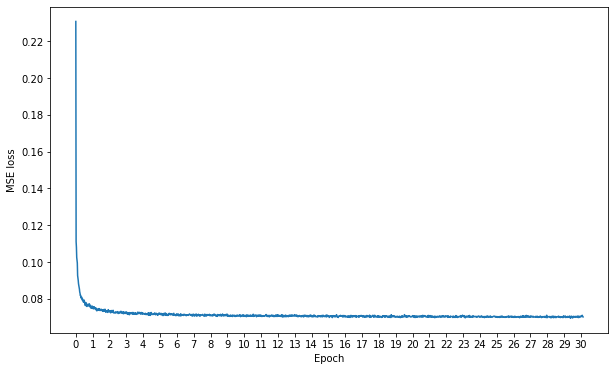

In [0]:
# print Graph

numbers_shown = 50

# take only some numbers from array
print_loss = []
for i in range(len(loss_load)):
    if i % numbers_shown == 0:
        print_loss.append(loss_load[i])

# create x labels and x ticks
ticks = []
labels = []
tick = 0
label = 0
epoch_frequency = int(len(loss_load) / epochs_load / numbers_shown)
while tick <= len(print_loss):
    ticks.append(tick)
    tick += epoch_frequency
    labels.append(str(label))
    label+=1

# make a plot and save png image
plt.figure(figsize=(10,6))
plt.plot(range(len(print_loss)),print_loss)
plt.ylabel('MSE loss')
plt.xlabel('Epoch')
plt.xticks(ticks,labels) 
# plt.show()
plt.savefig(PATH + "loss_mnist.png")

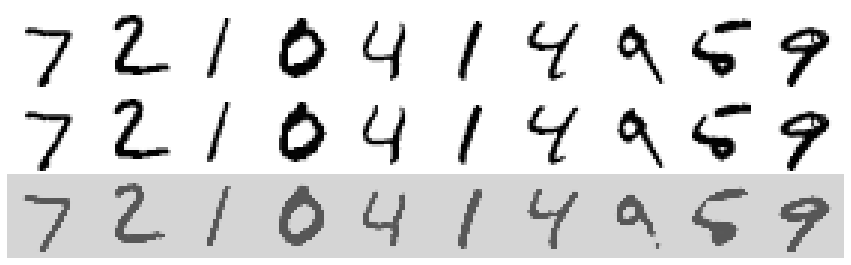

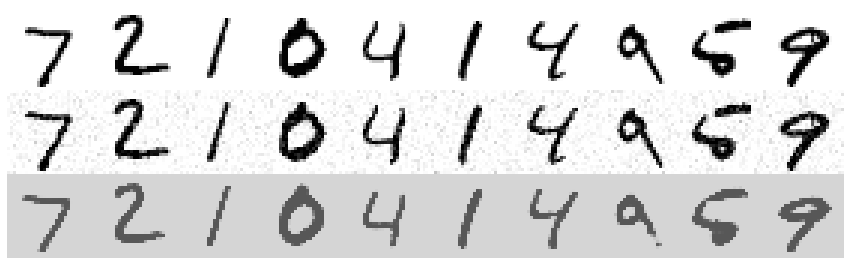

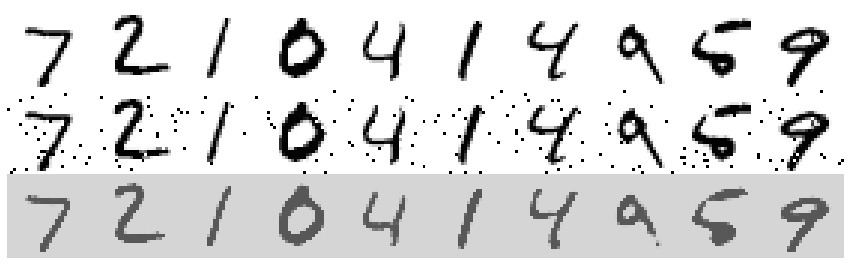

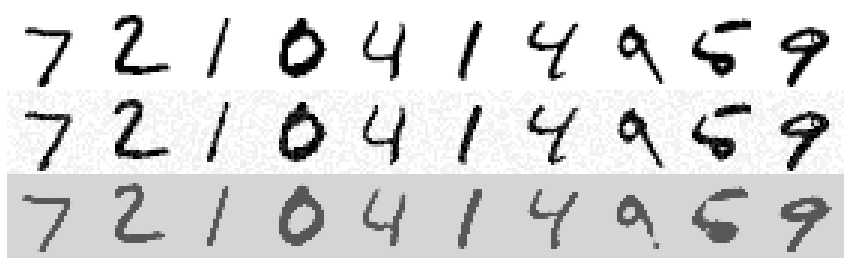

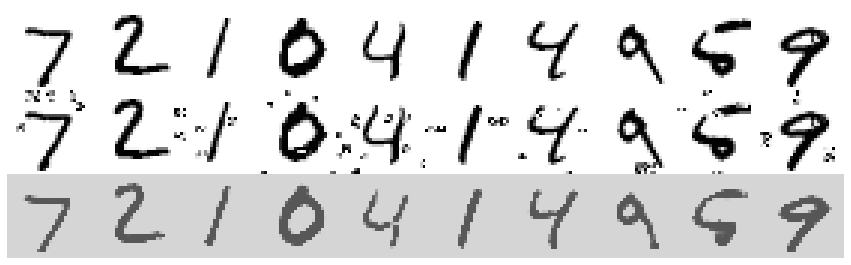

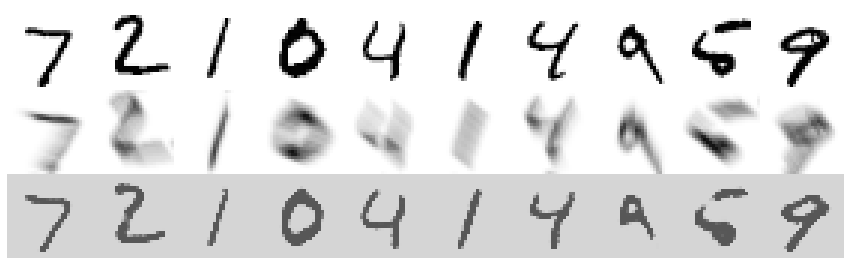

In [0]:
# Display the 1st 8 corrupted and denoised images
rows, cols =1, 10
TEST_SIZE = 10000
num = rows * cols

# tests = [x_test_fc,  x_test_gauss,  x_test_salt_pepper,  x_test_poisson,  x_test_dropout,  x_test_blur]
# i = 0
for i in range(6):

  imgs = np.concatenate([original_test_x[i*TEST_SIZE:num + i*TEST_SIZE], noise_test_x[i*TEST_SIZE:num + i*TEST_SIZE], x_decoded[i*TEST_SIZE:num + i*TEST_SIZE]])
  imgs = imgs.reshape((rows * 3, cols, 28, 28))
  imgs = np.vstack(np.split(imgs, rows, axis=1))
  imgs = imgs.reshape((rows * 3, -1, 28, 28))
  imgs = np.vstack([np.hstack(i) for i in imgs])
  # imgs = np.clip(imgs, 0., 1.)
  imgs = (imgs * 255).astype(np.uint8)

  plt.figure(figsize=(15,15))
  plt.axis('off')
  # plt.title('Original images: top rows, '
  #           'Corrupted Input: middle rows, '
  #           'Denoised Input:  third rows')
  plt.imshow(imgs, interpolation='none', cmap='Greys')
  Image.fromarray(255-imgs).save(PATH+f'corrupted_and_denoised_{i}.png')
  plt.show()



In [0]:
# load model for evaluation
model = load_model(PATH+'mnist_model')
model.load_weights(PATH+'mnist_best_weights.h5')
# score = model.evaluate(x_test_conv, y_test, verbose=0)
score = model.evaluate(x_decoded, noise_test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.835067354774475
Test accuracy: 0.233433336019516
